In [26]:
import tensorflow as tf
print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten
# from tensorflow.keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

2.19.0


In [11]:
import os
import numpy as np
import pandas as pd
from pathlib import Path



# Parameters
WINDOW_SIZE = 100   # samples per window
STEP_SIZE = 50      # overlap
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')   # parent folder with subfolders for each appliance
LABELS = []
X = []
y = []
well_represented = ['Microwave', 'Fridge', 'Television', 'Computer']


def process_file(file_path, label_idx):
    df = pd.read_csv(file_path)
    print(f"Processing file: {file_path}, Label index: {label_idx}")

    with open(file_path) as f:
      # Extract appliance name from filename
        appliance_name = f.readline().strip().split(",")[1]
        
    if appliance_name not in df.columns:
        return

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    signal = signal / np.max(np.abs(signal))

    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        X.append(window)
        y.append(label_idx)

def load_dataset(data_dir,well_represented=well_represented):
    global LABELS
    label_map = {name: i for i, name in enumerate(well_represented)}

    for class_dir in (sorted(Path(data_dir).iterdir())):
        if not class_dir.is_dir():
            continue

        class_name = class_dir.name
        if class_name not in well_represented:
            continue

        label_idx = label_map[class_name]
        LABELS.append(class_name)

        for file in class_dir.glob("*.csv"):
            process_file(file, label_idx)

# Load and preprocess data
load_dataset(DATA_DIR)
X = np.array(X)[..., np.newaxis]  # shape: [samples, window_size, 1]
y = to_categorical(y, num_classes=len(LABELS))


Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv, Label index: 3
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv, Label index: 3
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv, Label index: 3
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv, Label index: 3
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv, Label index: 3
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv, Label index: 3
Processi

In [12]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 926517 samples
Fridge              : 449381 samples
Microwave           : 848396 samples
Television          : 826402 samples

Class distribution in VALIDATION set:
Computer            : 309030 samples
Fridge              : 149694 samples
Microwave           : 282488 samples
Television          : 275687 samples

Class distribution in TEST set:
Computer            : 308951 samples
Fridge              : 149740 samples
Microwave           : 283276 samples
Television          : 274932 samples


In [13]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 5, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1:], len(LABELS))
model.summary()


c:\Users\niran\miniconda3\envs\cpu_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 96, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 46, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,932 (394.27 KB)

 Trainable params: 100,932 (394.27 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=32,
    verbose=1
)


95335/95335 ━━━━━━━━━━━━━━━━━━━━ 574s 6ms/step - accuracy: 0.6647 - loss: 0.7470 - val_accuracy: 0.6917 - val_loss: 0.6771


In [21]:
predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
print(probs)

31779/31779 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step
[0 3 0 ... 2 2 0]


In [22]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

Confusion matrix, without normalization
[[267802   2878  32814   5457]
 [ 60668  69126  17497   2449]
 [  5649   9390 217698  50539]
 [ 18603   5462 102146 148721]]


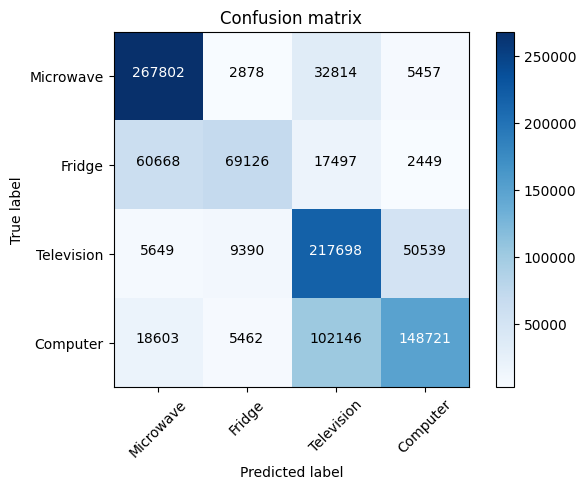

In [27]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)